## Author - Martin

In [2]:
import datetime
import os
import tempfile
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.stats import norm, lognorm, gamma
import numpy as np

from covid19sim.base import City, EmptyCity, Env
from covid19sim.simulator import Human
from covid19sim.constants import SECONDS_PER_DAY, SECONDS_PER_HOUR
from covid19sim.utils import parse_configuration, _get_disease_days

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

from pathlib import Path
import yaml
from omegaconf import OmegaConf

HYDRA_PATH = (
    Path().cwd().parent / "src/covid19sim/hydra-configs/simulation"
).resolve()

config = HYDRA_PATH / "config.yaml"

with config.open("r") as f:
    defaults = yaml.safe_load(f)["defaults"]

default_confs = [
    OmegaConf.load(str(HYDRA_PATH / (d + ".yaml")))
    for d in defaults
]

conf = OmegaConf.merge(*default_confs)
conf = parse_configuration(conf)


In [3]:
def piecewise_linear_peaky(x, rng, conf, NUM_PEOPLE, age, inflammatory_disease_level):
    """
    Plots viral load curves.
    
    **** **** **** **** **** **** **** **** **** **** **** **** **** 
    **** **** **** **** **** WARNING **** **** **** **** **** **** 
    /!\ Compuation logic is copy-pasted from `Human.viral_load_for_day`. 
    The changes to that file won't be reflected here. Only _get_disease_days is used from utils.py
    **** **** **** **** **** **** **** **** **** **** **** **** **** 
    **** **** **** **** **** **** **** **** **** **** **** **** **** 
    """

    viral_loads = []

    for person in range(NUM_PEOPLE):
        infectiousness_onset_days, viral_load_peak_start, \
            incubation_days, viral_load_plateau_start, viral_load_plateau_end, \
                recovery_days, viral_load_peak_height, viral_load_plateau_height = _get_disease_days(rng, conf, age, inflammatory_disease_level)

        # for ease of calculation, make viral load parameters relative to infectiousness onset
        viral_load_peak_start -= infectiousness_onset_days
        viral_load_plateau_start -= infectiousness_onset_days
        viral_load_plateau_end -= infectiousness_onset_days

        # precompute peak-plateau slope
        denominator = (viral_load_plateau_start - viral_load_peak_start)
        numerator =  viral_load_peak_height - viral_load_plateau_height
        peak_plateau_slope = numerator / denominator

        # percomupte plateau-end - recovery slope (should be negative because it is decreasing)
        numerator = viral_load_plateau_height
        denominator = recovery_days - viral_load_plateau_end
        plateau_end_recovery_slope = numerator / denominator

        viral_load = []
        for days_infectious in x:
            # Rising to peak
            if days_infectious < viral_load_peak_start:
                cur_viral_load = viral_load_peak_height * days_infectious / (viral_load_peak_start)

            # Descending to plateau from peak
            elif days_infectious < viral_load_plateau_start:
                days_since_peak = days_infectious - viral_load_peak_start
                cur_viral_load = viral_load_peak_height - peak_plateau_slope * days_since_peak

            # plateau duration
            elif days_infectious < viral_load_plateau_end:
                cur_viral_load = viral_load_plateau_height

            # during recovery
            else:
                days_since_plateau_end = days_infectious - viral_load_plateau_end
                cur_viral_load = viral_load_plateau_height - plateau_end_recovery_slope * days_since_plateau_end
                cur_viral_load = max(0, cur_viral_load) # clip it at 0

            viral_load.append(cur_viral_load)

        viral_loads.append(np.array(viral_load, dtype=float).flatten())
    viral_loads = np.array(viral_loads)
    return viral_loads


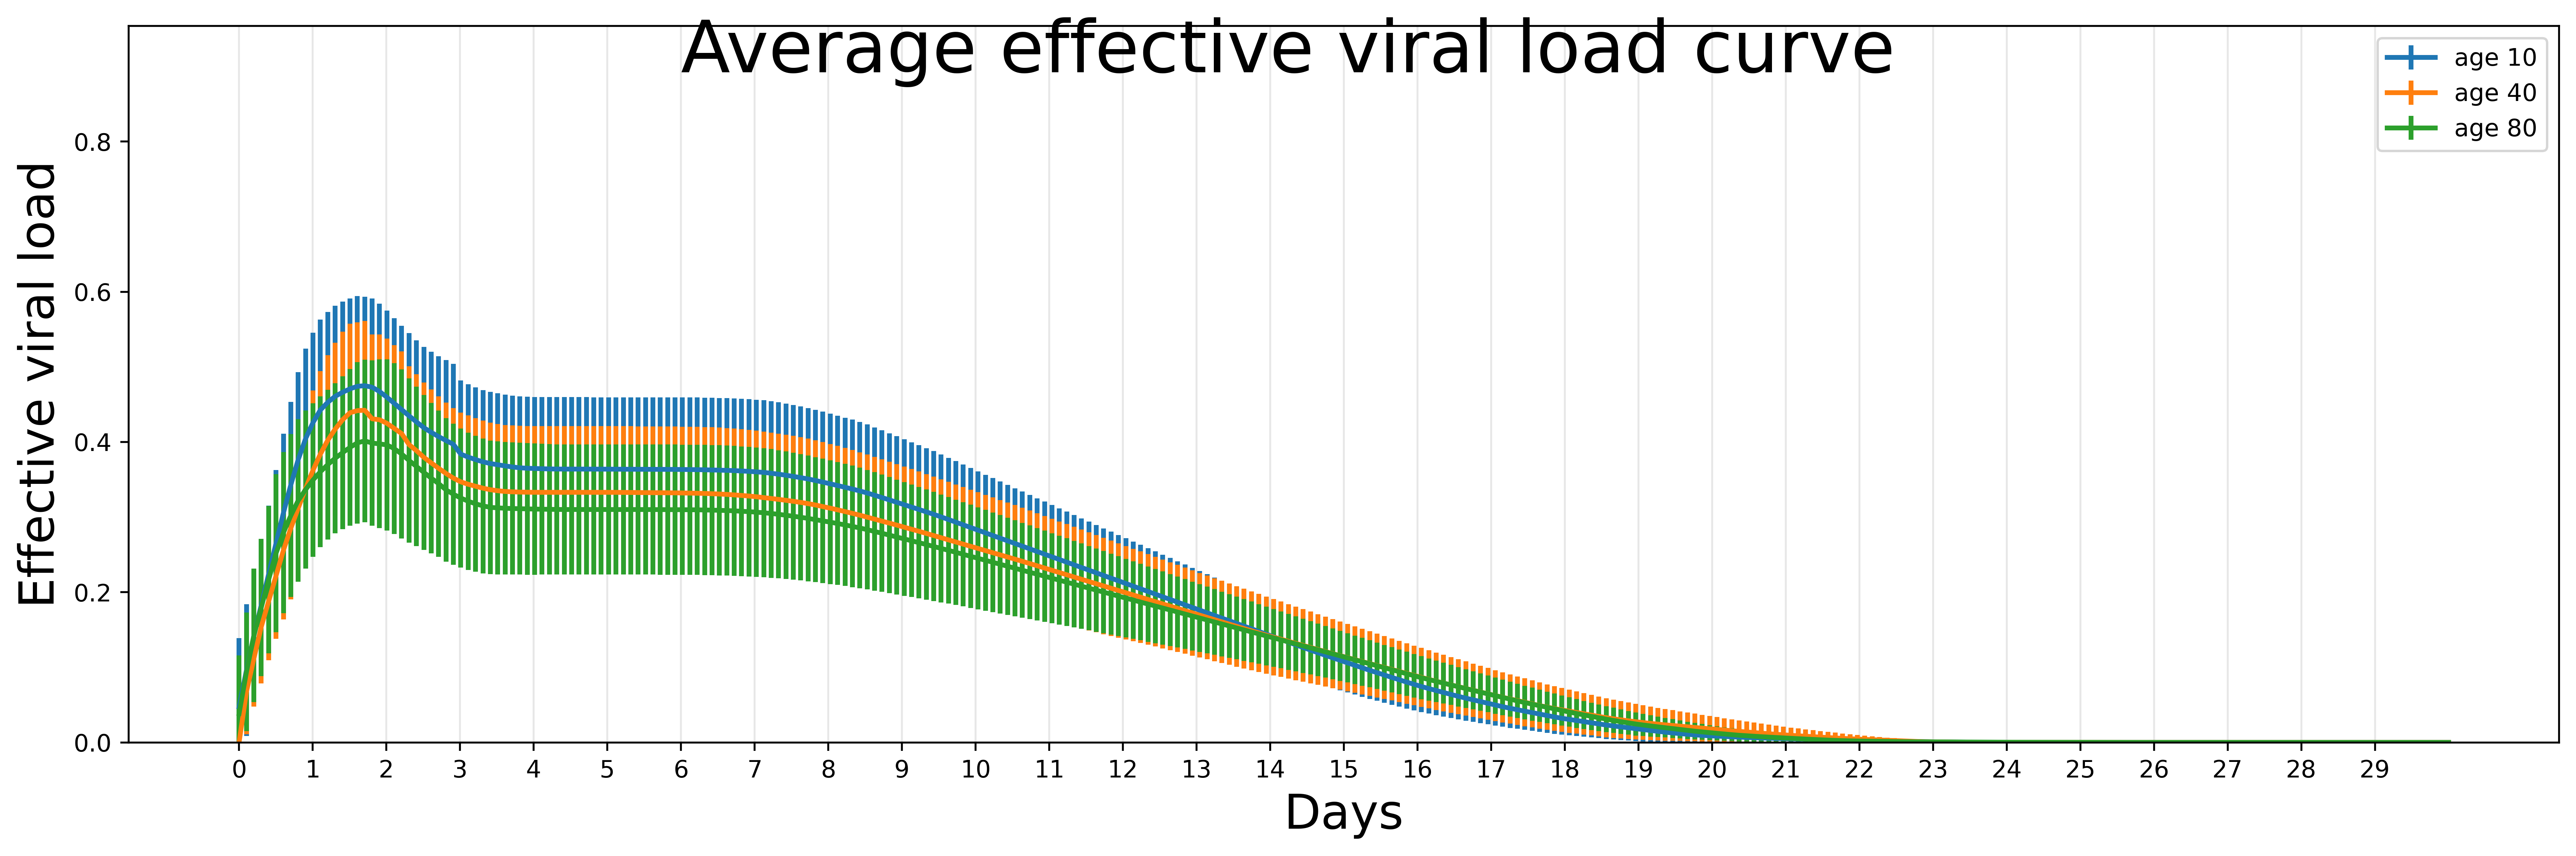

In [4]:
NUM_DAYS = 30
NUM_PEOPLE = 40
x = np.linspace(0, NUM_DAYS, 10*NUM_DAYS)
rng = np.random.RandomState(1)

# plot average viral load
fig, ax = plt.subplots(1, 1, figsize=(15,5), dpi=500)
for age in [10, 40, 80]:
    viral_loads_piecewise = piecewise_linear_peaky(x, rng, conf, NUM_PEOPLE, age, 0)
    ax.errorbar(x, viral_loads_piecewise.mean(axis=0), yerr=0.5*viral_loads_piecewise.std(axis=0), lw=2, label=f"age {age}")

plt.legend()

ax.grid(True, axis='x', alpha=0.3)
ax.set_xticks(np.arange(0,30,1))
ax.set_xlabel("Days", fontsize=20)
ax.tick_params(labelsize=10)

ax.set_ylim(0,viral_loads_piecewise.max())
ax.set_ylabel("Effective viral load", fontsize=20)

fig.suptitle("Average effective viral load curve", fontsize=30 )

plt.tight_layout()
fig.savefig("viral_load_curve.png")

In [5]:
# plot individual viral loads

viral_loads_piecewise = piecewise_linear_peaky(x, rng, conf, NUM_PEOPLE, age, 0)
for i in range(viral_loads_piecewise.shape[0]):
    ax.plot(x, viral_loads_piecewise[i], lw=2)

ax.grid(True, axis='x', alpha=0.3)
ax.set_xticks(np.arange(0,30,1))
ax.set_xlabel("Days", fontsize=20)
ax.tick_params(labelsize=10)

ax.set_ylim(0,viral_loads_piecewise.max())
ax.set_ylabel("Effective viral load", fontsize=20)

fig.suptitle("Average effective viral load curve", fontsize=30 )

plt.tight_layout()
fig.savefig("viral_load_curve_individual.png")

<Figure size 432x288 with 0 Axes>